# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
!pip install imblearn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')
phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

### Contract

In [4]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


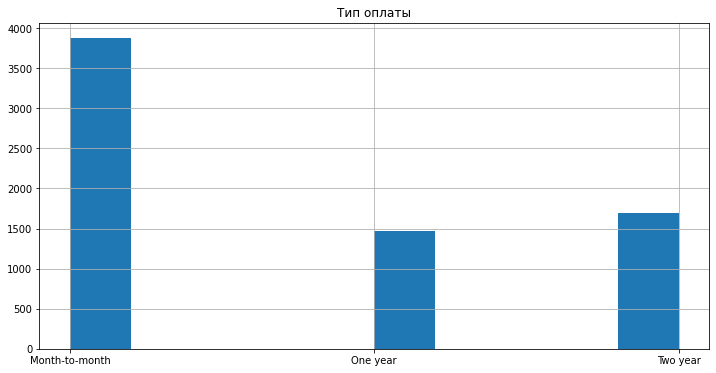

In [6]:
contract['Type'].hist(figsize=(12,6), bins=10)
plt.title('Тип оплаты');

На графике видно что, большинство клиентов выбирают платить каждый месяц, но также видно, что клиентов, которые оплачивают сразу на 2 года, больше, чем тех, которые оплачивают на год, возможно, это связанно с более лояльными условиями, предоставляемые тем кто оплачивает 2 года.

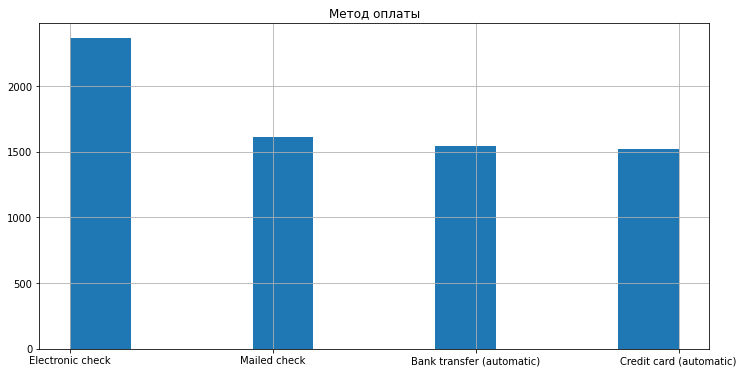

In [7]:
contract['PaymentMethod'].hist(figsize=(12,6), bins=10)
plt.title('Метод оплаты');

Чаще всего люди оплачивают электронно, что гораздно удобнее.

In [8]:
contract.pivot_table(index='Type', values='MonthlyCharges')

,MonthlyCharges
Type,
Month-to-month,66.398490
One year,65.048608
Two year,60.770413


Видно, что чем больше срок ты оплачиваешь, тем дешевле обходится каждый месяц. Выглядит логично

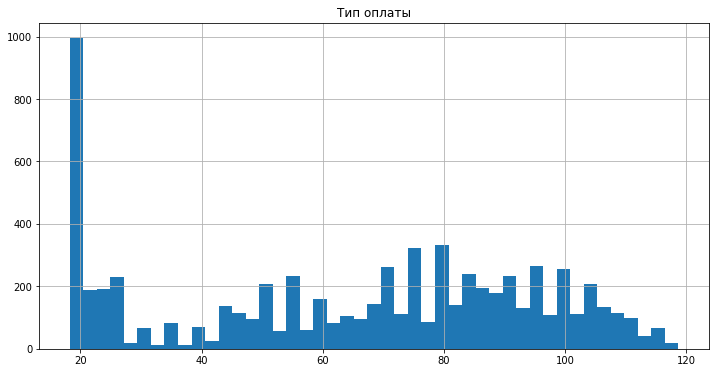

In [9]:
contract['MonthlyCharges'].hist(figsize=(12,6), bins=45)
plt.title('Тип оплаты');

Достаточно равномердное распределение. Странный пик в районе нуля

Вывод по датасету: <br>
    1. Необходимо изменить тип данных на datetime у столбца BeginDate и EndDate<br>
    2. Исследовать пик у столбца MonthlyCharges

### Personal

In [10]:
personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   int64 
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


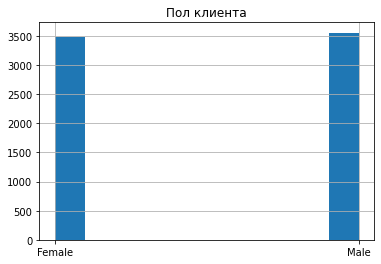

In [12]:
personal['gender'].hist()
plt.title('Пол клиента');

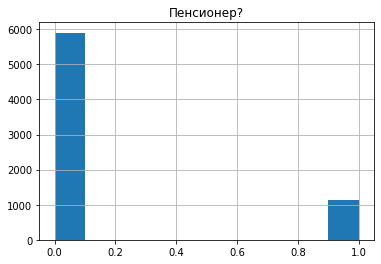

In [13]:
personal['SeniorCitizen'].hist()
plt.title('Пенсионер?');

Достаточно равномерно распределелилсь.

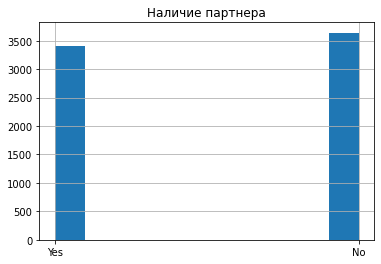

In [14]:
personal['Partner'].hist()
plt.title('Наличие партнера');

Небольшой перевес в сторону холостяков.

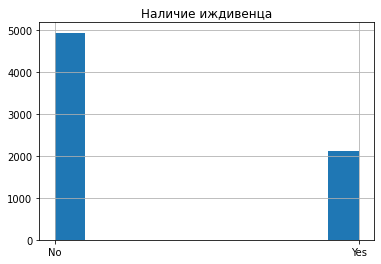

In [15]:
personal['Dependents'].hist()
plt.title('Наличие иждивенца');

Болошой перевес в сторону тех, у кого нет иждивенца.

Вывод: Достаточно не информативный датасет, но какую-то общую информацию о клиентах узнать удалось

### Internet

In [16]:
internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [17]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


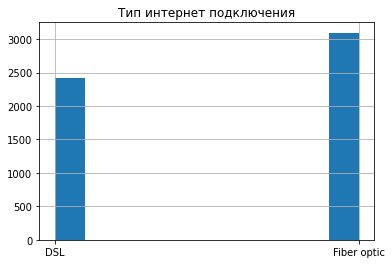

In [18]:
internet['InternetService'].hist()
plt.title('Тип интернет подключения');

Примерно поровну разделились пользователи по тип подключения, чуть больше используют оптоволокно, другие соединение через маршрутизатор.

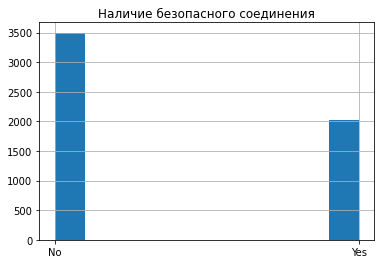

In [19]:
internet['OnlineSecurity'].hist()
plt.title('Наличие безопасного соединения');

Большая часть клиентов не пользуются функцией безопасного соединения.

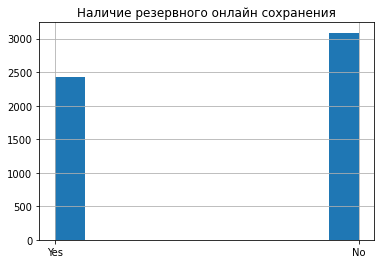

In [20]:
internet['OnlineBackup'].hist()
plt.title('Наличие резервного онлайн сохранения');

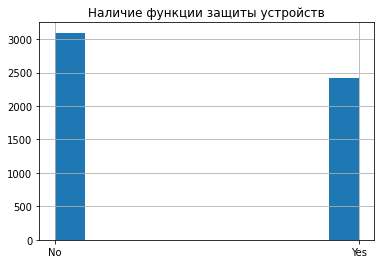

In [21]:
internet['DeviceProtection'].hist()
plt.title('Наличие функции защиты устройств');

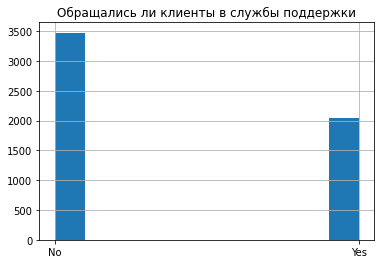

In [22]:
internet['TechSupport'].hist()
plt.title('Обращались ли клиенты в службы поддержки');

Большая часть не обращается к службе поддержки

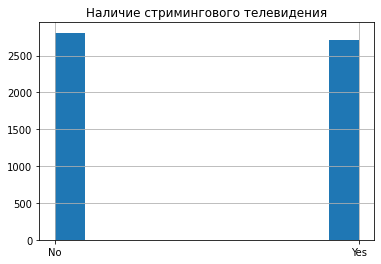

In [23]:
internet['StreamingTV'].hist()
plt.title('Наличие стримингового телевидения');

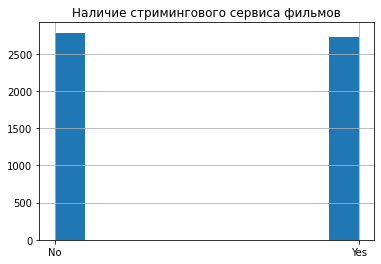

In [24]:
internet['StreamingMovies'].hist()
plt.title('Наличие стримингового сервиса фильмов');

В стриминговых услугах почти равное количество пользователей.

Вывод: <br>
У большинства пользователей, подключен оптоволоконный кабель, DSL обладает меньшей скоростью и его ставят обычно там где нет возможности провести оптоволоконный кабель например в частных домах. <br>
<br>
Пользователи чаще отказываются от доп услуг, что логично.<br>
<br>
Но с стриминговыми сервисами дела обстоят немного по-другому: примерно поровну распределены, те кто подключают и не подключат телевидение и сервисы с фильмами.

### Phone

In [25]:
phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [26]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


Не все пользователи попали в список

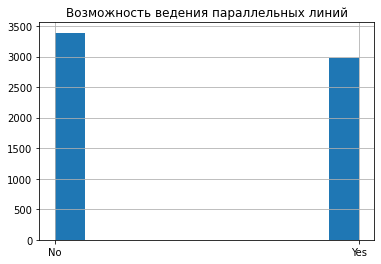

In [27]:
phone['MultipleLines'].hist()
plt.title('Возможность ведения параллельных линий');

Уточняющие вопросы:
1. Какой столбец целевой признак?
2. Что делать с пользователями, которые не попали в датасет phone?


План:
1. Объединить датасеты в один по index_col id клиента
2. Добавить целевой признак
3. Обучить модели

## Предобработка данных

Добавим целевой признак.

In [28]:
contract['Leave'] = (contract['EndDate'] != 'No').astype(int)

Выведем крайнюю дату выгрузки датасета и заполним значение No на эту дату в столбце EndDate.

In [29]:
contract['BeginDate'].max()

'2020-02-01'

In [30]:
contract['EndDate'] = contract['EndDate'].replace('No', '2020-02-01')

Заменим Dtype на datetime64.

In [31]:
contract['EndDate'] = contract['EndDate'].astype('datetime64')
contract['BeginDate'] = contract['BeginDate'].astype('datetime64')

In [32]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], downcast='float', errors = 'coerce')

In [33]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float32       
 7   Leave             7043 non-null   int64         
dtypes: datetime64[ns](2), float32(1), float64(1), int64(1), object(3)
memory usage: 467.7+ KB


In [34]:
contract['Days'] = (contract['EndDate'] - contract['BeginDate']).dt.days

In [35]:
contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Leave,Days
customerID,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.850000,0,31
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.500000,0,1036
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.150002,1,61
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.750000,0,1371
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.649994,1,61


In [36]:
final = contract \
    .merge(personal, how='left', on='customerID') \
    .merge(internet, how='left', on='customerID') \
    .merge(phone, how='left', on='customerID') 

In [37]:
final.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Leave,Days,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.850000,0,31,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.500000,0,1036,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.150002,1,61,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.750000,0,1371,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.649994,1,61,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No


In [38]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float32       
 7   Leave             7043 non-null   int64         
 8   Days              7043 non-null   int64         
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity

In [39]:
final.corr()

,MonthlyCharges,TotalCharges,Leave,Days,SeniorCitizen
MonthlyCharges,1.000000,0.651065,0.193356,0.247754,0.220173
TotalCharges,0.651065,1.000000,-0.199484,0.825811,0.102411
Leave,0.193356,-0.199484,1.000000,-0.352673,0.150889
Days,0.247754,0.825811,-0.352673,1.000000,0.016514
SeniorCitizen,0.220173,0.102411,0.150889,0.016514,1.000000


Столбец TotalCharges сильно коррелирует со столбцами MonthlyCharges и Days. Чем дольше человек пользуется услугами, тем больше общую сумму он заплатит, что логично, поэтому данный столбец следует удалить. Также удалим столбцы с датами.

In [40]:
final = final.drop(['BeginDate', 'EndDate', 'TotalCharges'], axis = 1)

Необходимо заполнить пропуски. Все пропуски заполним на 'No'.

In [41]:
final = final.fillna('No')

In [42]:
final.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,Leave,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,0,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
5575-GNVDE,One year,No,Mailed check,56.95,0,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,1,61,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,0,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,1,61,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Датасет готов к обучению.

## Подготовка к обучению

In [43]:
RANDOM_STATE = 220523

Разделим выборку на тренировочную и тестовую в соотношении75/25

In [44]:
X = final.drop('Leave', axis=1)
y = final['Leave']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [46]:
ohe_features= X_train.select_dtypes(include='object').columns.to_list()
numeric = ['MonthlyCharges', 'Days']

Применим One-Hot Encoding, так как в датасете присутствуют категориальные столбцы. Чтобы не попасть в дамми-ловушку, применим параметр drop_first=True

In [47]:
X_train_ridge = X_train.copy()
X_test_ridge = X_test.copy()

In [48]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough, чтобы он не пропал 
col_transformer_ridge = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        ohe_features
    ),
    (
        StandardScaler(), 
        numeric
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

# всё готово в пару строк кода
X_train_transformed = col_transformer_ridge.fit_transform(X_train)

# Convert the transformed array to a DataFrame
X_train_ridge = pd.DataFrame(X_train_transformed, columns=col_transformer_ridge.get_feature_names_out())

# Display the resulting DataFrame
X_train_ridge.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,Days,SeniorCitizen
0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.832674,1.027630,1.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.626683,-0.563242,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.206449,1.516408,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.148306,1.516408,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.543676,1.394549,0.0


In [49]:
# Transform the test data
X_test_transformed = col_transformer_ridge.transform(X_test)

# Convert the transformed array to a DataFrame
X_test_ridge = pd.DataFrame(X_test_transformed, columns=col_transformer_ridge.get_feature_names_out())

# Display the resulting DataFrame
X_test_ridge.head()

,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,Partner_Yes,Dependents_Yes,InternetService_Fiber optic,...,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes,MonthlyCharges,Days,SeniorCitizen
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.037004,1.229837,0.0
1,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.045256,1.271350,0.0
2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.973878,0.415654,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.377554,1.311523,1.0
4,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.070229,-0.114637,0.0


## Обучение

### Логистическая регрессия 

In [50]:
lr = LogisticRegression(random_state=RANDOM_STATE)
param_lr = {
    'solver':['lbfgs', 'saga', 'sag', 'newton-cholesky'],
    'C':[0.001, 0.01, 0.1, 1, 10]
}

In [51]:
grid_lr = GridSearchCV(lr, param_lr, scoring='roc_auc', n_jobs=-1)

In [52]:
%%time
grid_lr.fit(X_train_ridge, y_train)

CPU times: user 11 s, sys: 23.8 s, total: 34.7 s
Wall time: 36 s


GridSearchCV(estimator=LogisticRegression(random_state=220523), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'solver': ['lbfgs', 'saga', 'sag', 'newton-cholesky']},
             scoring='roc_auc')

In [53]:
print('Качество модели по кросс-валидации', grid_lr.best_score_)

Качество модели по кросс-валидации 0.8432087447728781


In [54]:
grid_lr.best_params_

{'C': 10, 'solver': 'sag'}

### Метод случайного леса

In [55]:
forest = RandomForestClassifier(random_state=RANDOM_STATE)
forest_params = {
    'max_depth':list(range(16,26)),
    'min_samples_leaf':[1,2,3,4,5],
    'min_samples_split':[2,3,4,5]
}

In [56]:
forest_grid = GridSearchCV(forest, forest_params, scoring='roc_auc', n_jobs=-1, cv=3)

In [57]:
%%time
forest_grid.fit(X_train_ridge, y_train)

CPU times: user 4min 32s, sys: 0 ns, total: 4min 32s
Wall time: 4min 41s


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=220523),
             n_jobs=-1,
             param_grid={'max_depth': [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 3, 4, 5]},
             scoring='roc_auc')

In [58]:
print('Качество модели по кросс-валидации', forest_grid.best_score_)

Качество модели по кросс-валидации 0.8516841184308811


In [59]:
forest_grid.best_params_

{'max_depth': 16, 'min_samples_leaf': 5, 'min_samples_split': 2}

### CatBoostClassifier

In [60]:
cat = CatBoostClassifier(random_seed=RANDOM_STATE, learning_rate=0.1, iterations=2000, eval_metric='AUC')
param_cat = {'depth':[6,8,10], 
            'l2_leaf_reg':[3,6,9]}

In [61]:
cat_grid = GridSearchCV(cat, param_cat, scoring='roc_auc', n_jobs=-1, cv=3)

In [62]:
%%time
cat_grid.fit(X_train_ridge, y_train)

0:	total: 53.3ms	remaining: 1m 46s
1:	total: 56ms	remaining: 55.9s
2:	total: 58.5ms	remaining: 38.9s
3:	total: 61ms	remaining: 30.4s
4:	total: 62.9ms	remaining: 25.1s
5:	total: 64.8ms	remaining: 21.5s
6:	total: 66.9ms	remaining: 19s
7:	total: 69ms	remaining: 17.2s
8:	total: 71ms	remaining: 15.7s
9:	total: 73ms	remaining: 14.5s
10:	total: 74.9ms	remaining: 13.5s
11:	total: 76.8ms	remaining: 12.7s
12:	total: 78.6ms	remaining: 12s
13:	total: 80.5ms	remaining: 11.4s
14:	total: 82.5ms	remaining: 10.9s
15:	total: 84.4ms	remaining: 10.5s
16:	total: 86.4ms	remaining: 10.1s
17:	total: 87.8ms	remaining: 9.67s
18:	total: 89.9ms	remaining: 9.37s
19:	total: 92ms	remaining: 9.11s
20:	total: 94ms	remaining: 8.86s
21:	total: 95.9ms	remaining: 8.62s
22:	total: 97.2ms	remaining: 8.35s
23:	total: 99.1ms	remaining: 8.16s
24:	total: 101ms	remaining: 7.98s
25:	total: 103ms	remaining: 7.82s
26:	total: 105ms	remaining: 7.68s
27:	total: 107ms	remaining: 7.53s
28:	total: 109ms	remaining: 7.43s
29:	total: 112ms	

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x7fc6ca897f40>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'l2_leaf_reg': [3, 6, 9]},
             scoring='roc_auc')

In [63]:
print('Качество модели по кросс-валидации', cat_grid.best_score_)

Качество модели по кросс-валидации 0.8980610713601956


In [64]:
cat_grid.best_params_

{'depth': 6, 'l2_leaf_reg': 9}

## Тестирование лучшей модели

Лучшей моделью оказался CatBoostClassifier. Построим для него ROC-кривую.

In [65]:
def plot_roc_curve(y_test, pred):
    print('ROC-AUC score', roc_auc_score(y_test, pred))
    
    fpr, tpr, thresholds = roc_curve(y_test, pred)

    plt.figure(figsize=(15, 7))
    
    plt.plot(fpr, tpr)
    
    plt.plot([0, 1], [0, 1], linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title('ROC-кривая')
    
    plt.show()

ROC-AUC score 0.9209824162365496


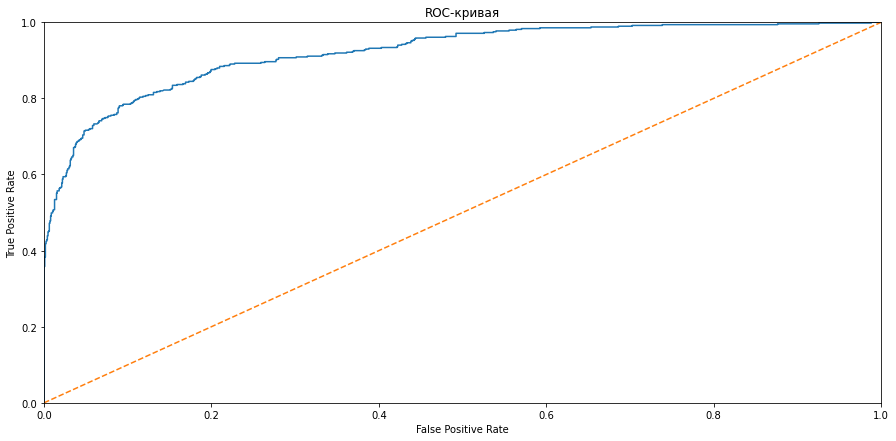

In [66]:
pred = cat_grid.best_estimator_.predict_proba(X_test_ridge)[:, 1]
plot_roc_curve(y_test, pred)

In [67]:
# Получение важности параметров и их названий
feature_importances = cat_grid.best_estimator_.feature_importances_
feature_names = X_train_ridge.columns

# Создание DataFrame с важностью параметров
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Сортировка по важности
importance_df = importance_df.sort_values('Importance', ascending=False)

# Вывод важности параметров
importance_df

,Feature,Importance
19,Days,43.045149
18,MonthlyCharges,15.665777
1,Type_Two year,4.040744
2,PaperlessBilling_Yes,3.314561
7,Partner_Yes,2.859277
4,PaymentMethod_Electronic check,2.843673
6,gender_Male,2.545132
9,InternetService_Fiber optic,2.435462
0,Type_One year,2.288021
17,MultipleLines_Yes,2.139886


Вывод: Самым важным параметром с отрывом является количество дней. Также нам удалось достичь высокого показателя ROC AUC score на тестовой выборке. Есть подозрения на переобучение, возможно, это из-за борьбы с дизбалансом.

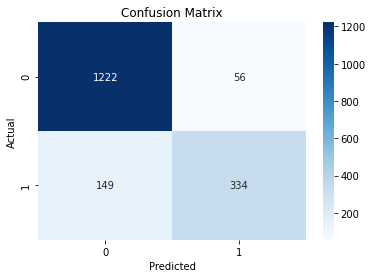

In [68]:
predict = cat_grid.best_estimator_.predict(X_test_ridge)
cm = confusion_matrix(y_test, predict)

# Создание цветовой карты с помощью seaborn
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

# Добавление подписей осей
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Добавление заголовка
plt.title('Confusion Matrix')

# Отображение графика
plt.show()

Модель делает достаточно большоек количество FN ошибок. Возможно, это связано с тем, что присутствует дизбаланс классов.

## Отчет по проделанной работе

Дано было задание спрогнозировать отток клиентов компании 'Ниединогоразрыва.ком', для того чтобы компания могла подстраховать себя и в случае если клиент планирует уйти предложить ему скидки и промокоды.



### Подготовка и загрузка данных

На вход мы получили 4 датасета:

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

После анализа датасетов было выяснено, что не все клиенты пользуются услугами интернета и/или телефонии. Услугами интернета пользуется 5517 абонентов, а телефонией 6361 абонент.

### Исследовательский анализ данных

Анализ показал, большинство клиентов выбирают платить каждый месяц, но также видно, что клиентов, которые оплачивают сразу на 2 года, больше, чем тех, которые оплачивают на год, возможно, это связанно с более лояльными условиями, предоставляемые тем кто оплачивает 2 года. Чем больше срок ты оплачиваешь, тем дешевле обходится каждый месяц, что соответствует ценовой политике большинства компаний. <br>
Исследовательский анализ показал, что большинство пользователей не пользуются дополнительными услугами, либо делились поровну: на тех, кто пользуется и тех, кто не пользуется. 

### Предобработка данных

Предобработка данных заключалась в заполнении пропусков, выделении дополнительных признаков (количество дней) и удалении ненужных признаков (дата начала и конца договора). После этого 4 датасете были объединены в один.

### Подготовка к обучению, обучение и проверка на тестовой выборке

Подготовка к обучению заключалась в применении OneHot Encodingе и Стандартизации данных, так как в датасете много категориальных данных, с которыми не работает большинство моделей МО. Метрикой классификации была выбрана AUC-ROC, так как она устойчива к несбланасированным классам.<br>
Для обучения использовались 3 модели:
1. Логистическая регрессия
2. Случайный лес
3. CatBoost 
<br><br>Для всех моделей были подобраны оптимальные гиперпараметры с помощью GridSearchCV. Лучше всех себя проявил CatBoostClassifier со средним результат по кросс-валидации 0.8980610713601956, хуже всех - Логистическая регрессия - с результатом 0.8432087447728781. <br>
На тестовой выборке тестировалась лучшая модель, а именно CatBoost. ROC-AUC score составил 0.9209824162365496, что выше того, который был обозначен в ТЗ.

Матрица ошибок показала:
- `Верно предсказанных объектов класса 0` — 1222;
- `Ложно предсказанных объектов класса 1` — 56;
- `Ложно предсказанных объектов класса 0` — 149;
- `Верно предсказанных объектов класса 1` — 334.


### Итог

1. Какие пункты плана были выполнены, а какие — нет. Почему? Были выполнены все пункты по ТЗ. Думаю, что следовало провести дополнительный исследовательский анализ на корреляцию признаков и вывести дополнительные закономерности.

2. Какие трудности возникли и как вы их преодолели? Во время выполнения проекта не возникало никаких трудностей. Датасеты были корректные, ТЗ было обозначено четко, в связи с чем удалось достичь необходимого результата.

3. Какие ключевые шаги в решении задачи вы выделили?
Важными этапами при выполнения работы считаю были:
1) правильное соединение данных
2) выделение целевого признака и дополнительных признаков
3) обработка пропусков
4) предобработка данных перед обучения
5) выбор модели

4. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество? Итоговой моделью оказался CatBoostClassifier. Гиперпараметры: количество итераций - 2000, глубина дерева - 6, регуляризация - 9
На тестовой выборке AUC-ROC составил 0.9209824162365496

5. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена? Для обучения модели датасет был разделен на обучающую (X_train) и тестовую (X_test) в соотношении 4:1 (75%, 25%). Значения каждой выборки категоризированы, но не сбалансированы - ответов «клиент ушел» и «клиент остался» в выборке не поровну (27% на 73%). Все признаки были разделены на два вида: 

- `Категориальные` — Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, MultipleLines, Type, PaperlessBilling, PaymentMethod, Gender;
- `Числовые` — MontlyCharges, TotalCharges, Leave (целевой признак);


В связи с тем, что многие модели МО не умеют работать с категориальными данными, было применено One-Hot Encoding с помощью OneHotEncoder с параметром drop_first=True, чтобы не попасть в дамми-ловушку. Также из-за того, что числовые признаки имели разный масштаб, была применена стандартизация с помощью StandartScaler. После этого датасет отправился на обучения на моделях.

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">

    
----  
    
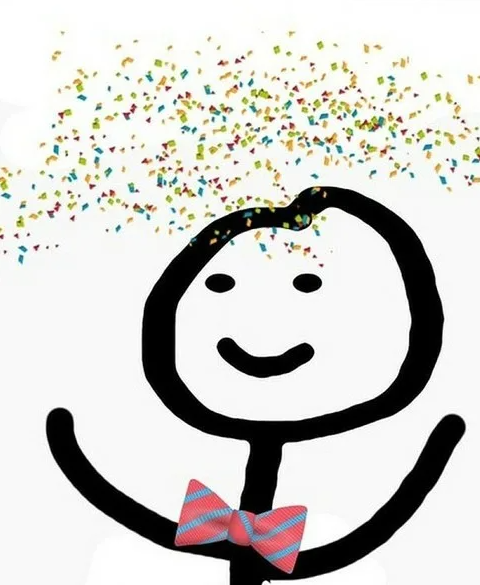
    
</div>
